In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score , precision_score , recall_score , confusion_matrix , ConfusionMatrixDisplay , classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot  as plt
import gradio as gr
import seaborn as sns

In [15]:
Spam_data = pd.read_csv("combined_data.csv")
Spam_data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [16]:
Spam_data.isna().sum()

label    0
text     0
dtype: int64

In [17]:
x = Spam_data["text"]
y = Spam_data["label"]


In [18]:
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size=0.2 , random_state=42)

print(f"len of train {len(x_train)} ")
print(f"len of test {len(y_test)} ")

len of train 66758 
len of test 16690 


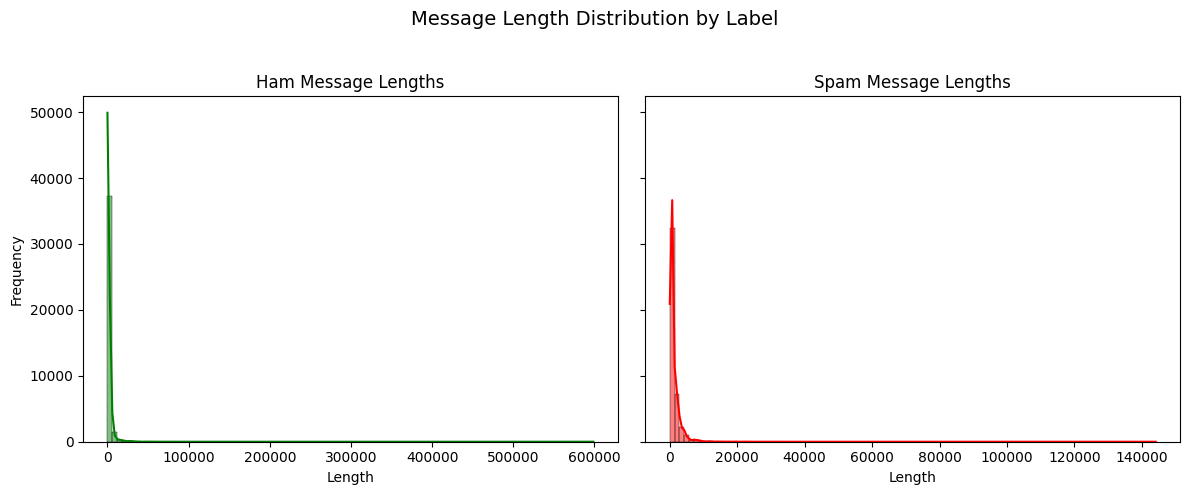

In [19]:

Spam_data['message_length'] = Spam_data['text'].apply(len)


fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)


sns.histplot(Spam_data[Spam_data['label'] == 0]['message_length'], bins=100, kde=True, color='green', ax=ax[0])
ax[0].set_title('Ham Message Lengths')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')


sns.histplot(Spam_data[Spam_data['label'] == 1]['message_length'], bins=100, kde=True, color='red', ax=ax[1])
ax[1].set_title('Spam Message Lengths')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')


fig.suptitle('Message Length Distribution by Label', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\Antwan Gamil\AppData\Local\Temp\ipykernel_10840\2494068275.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=colors, ax=ax[0])


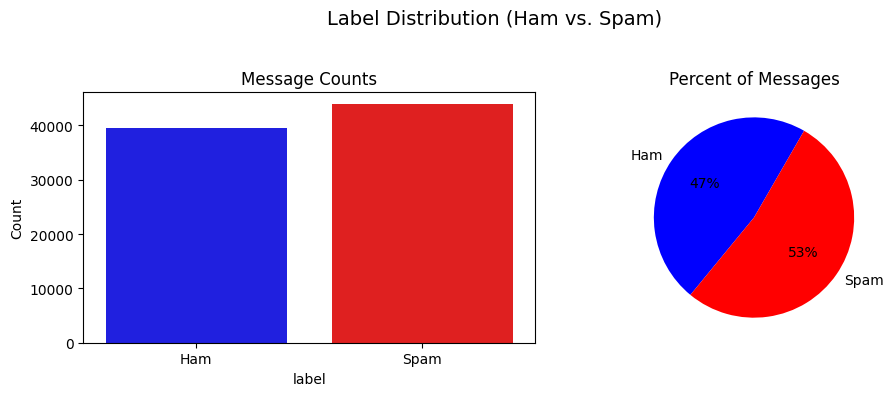

In [20]:

counts = Spam_data['label'].value_counts().sort_index()  # index 0=ham, 1=spam


fig, ax = plt.subplots(1, 2, figsize=(10, 4))


colors = ['blue', 'red']
sns.barplot(x=counts.index, y=counts.values, palette=colors, ax=ax[0])
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Ham', 'Spam'])
ax[0].set_ylabel('Count')
ax[0].set_title('Message Counts')


counts.plot.pie(
    autopct='%1.0f%%',
    startangle=60,
    labels=['Ham', 'Spam'],
    colors=colors,
    ax=ax[1]
)
ax[1].set_ylabel('')
ax[1].set_title('Percent of Messages')


fig.suptitle('Label Distribution (Ham vs. Spam)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [22]:
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english',ngram_range=(1,2) )
x_trained_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test) 

In [23]:
model = LogisticRegression(
    C=0.1,                # Stronger regularization (lower = more penalty)
    penalty='l2',         # L2 regularization
    solver='liblinear',   # Works well for small/medium datasets
    class_weight='balanced',  # Handle imbalanced data
    max_iter=1000
)
model.fit(x_trained_vectorized , y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
cv_scores = cross_val_score(model, x_trained_vectorized , y_train, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy: 0.9742202916516083


In [25]:
y_pred = model.predict(x_test_vectorized)

In [26]:
print (classification_report( y_test , y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7938
           1       0.97      0.99      0.98      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690



In [27]:
print(accuracy_score(y_test , y_pred))

0.9784901138406231


In [28]:
model.score(x_trained_vectorized , y_train)

0.977725516043021

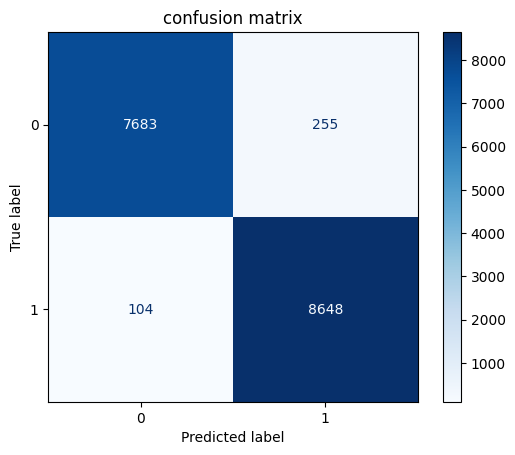

In [29]:
cm = confusion_matrix(y_test , y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap="Blues", values_format="d")

plt.title("confusion matrix")

plt.show()

In [30]:
x_2 = Spam_data["text"]    
y_2 = Spam_data["label"]


x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    x_2, y_2, test_size=0.2, random_state=42
)


vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_train = vectorizer.fit_transform(x_train_2)
X_test = vectorizer.transform(x_test_2)


model = LogisticRegression(
    C=0.1,                # Stronger regularization (lower = more penalty)
    penalty='l2',         # L2 regularization
    solver='liblinear',   # Works well for small/medium datasets
    class_weight='balanced',  # Handle imbalanced data
    max_iter=1000
)


# 4) Cross Validation to check stability
cv_scores = cross_val_score(model, X_train, y_train_2, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())

# 5) Train the model
model.fit(X_train, y_train_2)

def predict_spam(message):
    message_vec = vectorizer.transform([message])
    prediction = model.predict(message_vec)[0]
    return "Spam" if prediction == 1 else "Not Spam"

# Create Gradio interface
interface = gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(lines=3, placeholder="Enter your message here..."),
    outputs="text",
    title="Spam Detector",
    description="Enter a message and find out if it's Spam or Not Spam."
)

interface.launch()


Cross-Validation Accuracy: 0.970490394415536
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [ ]:
# ==========================
# Logistic Regression Model to Avoid Overfitting
# ==========================

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Example: data (X_text, y)
# Use your dataset
x_2 = Spam_data["text"]    
y_2 = Spam_data["label"]

# 1) Train / Test split
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    x_2, y_2, test_size=0.2, random_state=42
)

# 2) Tfidf with limited features (to avoid overfitting)
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_train = vectorizer.fit_transform(x_train_2)
X_test = vectorizer.transform(x_test_2)

# 3) Logistic Regression with Regularization + balanced classes
model = LogisticRegression(
    C=0.1,                # Stronger regularization (lower = more penalty)
    penalty='l2',         # L2 regularization
    solver='liblinear',   # Works well for small/medium datasets
    class_weight='balanced',  # Handle imbalanced data
    max_iter=1000
)

# 4) Cross Validation to check stability
cv_scores = cross_val_score(model, X_train, y_train_2, cv=5)
print("Cross-Validation Accuracy:", cv_scores.mean())

# 5) Train the model
model.fit(X_train, y_train_2)

# 6) Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test_2, y_pred))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred))


Cross-Validation Accuracy: 0.970490394415536
Test Accuracy: 0.9741761533852606

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      7938
           1       0.97      0.98      0.98      8752

    accuracy                           0.97     16690
   macro avg       0.97      0.97      0.97     16690
weighted avg       0.97      0.97      0.97     16690



In [32]:
from sklearn.svm import LinearSVC

model_3 = LinearSVC(class_weight='balanced', max_iter=5000)

model_3.fit(x_trained_vectorized , y_train) 

print(f"train score ", model_3.score(x_trained_vectorized,y_train))
print(f"acc", accuracy_score(y_test , y_pred))

train score  0.9979777704544773
acc 0.9784901138406231


In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)

clf.fit(x_trained_vectorized , y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
clf.score (x_test_vectorized , y_test)

0.9868783702816057

In [35]:
clf .score(x_trained_vectorized , y_train)

0.9996255130471254

Number of sample in each class:
Class 1: 43910 samples
Class 0: 39538 samples
Class 1: 52.62%
Class 0: 47.38%


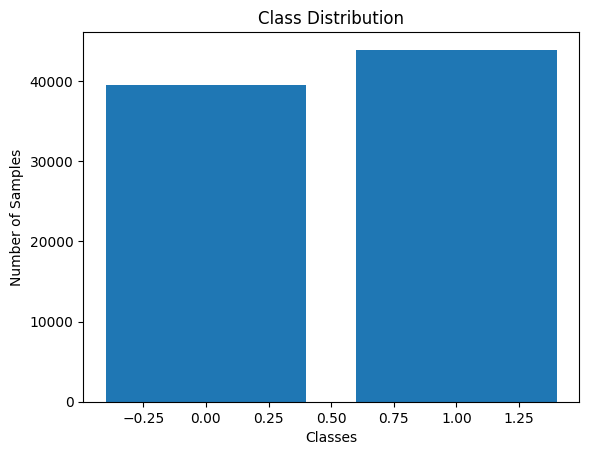

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


counter = Counter(y)

print("Number of sample in each class:")
for label, count in counter.items():
    print(f"Class {label}: {count} samples")


total = sum(counter.values())
for label, count in counter.items():
    print(f"Class {label}: {count/total:.2%}")


plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.show()


In [38]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight="balanced"),
    "LinearSVC": LinearSVC(max_iter=5000, class_weight="balanced"),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=200, class_weight="balanced", n_jobs=-1)
}

result = []



for name , mod in models.items(): 

        mod.fit(x_trained_vectorized , y_train)
        y_pred = mod.predict(x_test_vectorized)
        acc = accuracy_score(y_test , y_pred)
        result.append({"Model": name , "accuracy" :acc })




result_df = pd.DataFrame(result).sort_values(by="accuracy" , ascending=False).reset_index(drop=True)
print(result_df)

                    Model  accuracy
0               LinearSVC  0.989994
1      LogisticRegression  0.987418
2  RandomForestClassifier  0.986938
